In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    roc_curve,
    RocCurveDisplay, 
    precision_recall_curve,
    PrecisionRecallDisplay,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from scipy.stats import randint
import numpy as np

### Loading the train set

In [ ]:
X_train = pd.read_csv("../../Data/processed/processed_rf/train_X.csv")
y_train = pd.read_csv("../../Data/processed/processed_rf/train_y.csv")

In [3]:
X_train["Yearly Income - Person"] = X_train["Yearly Income - Person"].str.replace("$","",regex=False).astype(float)
X_train["Total Debt"] = X_train["Total Debt"].str.replace("$","",regex=False).astype(float)
X_train["Credit Limit"] = X_train["Credit Limit"].str.replace("$","",regex=False).astype(float)
X_train["Card on Dark Web"] = X_train["Card on Dark Web"].replace("No", 0)
X_train = X_train.drop(columns=["User","Card","DateTime","Date","User_card"])

C:\Users\wyk28\AppData\Local\Temp\ipykernel_7308\2007215091.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train["Card on Dark Web"] = X_train["Card on Dark Web"].replace("No", 0)


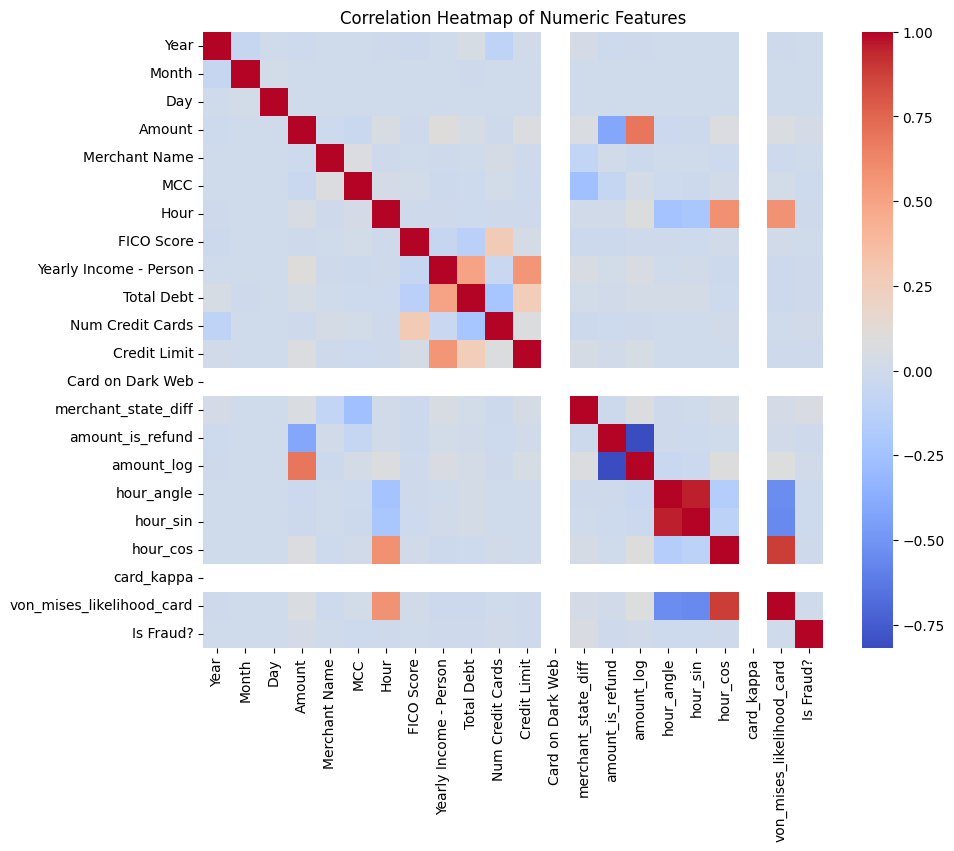

In [4]:
# Visualise the correlation of the numeric features 

df_train = pd.concat([X_train, y_train], axis=1)
corr = df_train.select_dtypes(include=["number", "bool"]).corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

### Hyperparameter tuning

In [5]:
# To perform encoding of textual features

categorical_cols = ['Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State', 'Errors?', 'Zip_str','State','Card Brand']
encoder = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
         categorical_cols)
    ],
    remainder="passthrough"
)

In [6]:
# Cross-validation pipeline with encoding and sampling applied within each fold

pipeline = ImbPipeline(steps=[
    ("encoder", encoder),
    ("undersample", RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ("model", RandomForestClassifier(random_state=42))
])

In [8]:
# Perform RandomizedSearchCV for hyperparameter tuning of random forest

param_dist = {
    "undersample__sampling_strategy": [0.02, 0.05, 0.1, 0.2],
    "model__n_estimators": [200,250,300,350,400],
    "model__max_depth": list(range(5, 15, 5)),
    "model__min_samples_split": randint(2, 20),
    "model__min_samples_leaf": randint(1, 10),
    "model__max_features": ["sqrt", "log2", 0.5, 0.7],
    "model__class_weight": ["balanced", "balanced_subsample",None]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    scoring={"roc_auc": "roc_auc", "pr_auc": "average_precision"},
    refit="pr_auc",
    cv=3,                         
    verbose=3,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("\nBest parameters found:")
print(search.best_params_)
print(f"Best Validation PR-AUC (from search): {search.best_score_:.4f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\wyk28\Documents\GitHub\Credit-Card-Fraud-Detection\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



Best parameters found:
{'model__class_weight': None, 'model__max_depth': 10, 'model__max_features': 0.7, 'model__min_samples_leaf': 9, 'model__min_samples_split': 15, 'model__n_estimators': 250, 'undersample__sampling_strategy': 0.05}
Best Validation PR-AUC (from search): 0.6412


### Random Forest Classifier

In [9]:
best_para = search.best_params_
best_rf = search.best_estimator_

In [ ]:
# Loading the test dataset

X_test = pd.read_csv("../../Data/processed/processed_rf/test_X.csv")
y_test = pd.read_csv("../../Data/processed/processed_rf/test_y.csv")

In [11]:
X_test["Yearly Income - Person"] = X_test["Yearly Income - Person"].str.replace("$","",regex=False).astype(float)
X_test["Total Debt"] = X_test["Total Debt"].str.replace("$","",regex=False).astype(float)
X_test["Credit Limit"] = X_test["Credit Limit"].str.replace("$","",regex=False).astype(float)
X_test["Card on Dark Web"] = X_test["Card on Dark Web"].replace("No", 0)
X_test = X_test.drop(columns=["User","Card","DateTime","Date","User_card"])

C:\Users\wyk28\AppData\Local\Temp\ipykernel_7308\257028469.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_test["Card on Dark Web"] = X_test["Card on Dark Web"].replace("No", 0)


In [36]:
# Evaluate tuned model on test dataset

y_test_pred_proba = best_rf.predict_proba(X_test)[:, 1]
roc_test = roc_auc_score(y_test, y_test_pred_proba)
pr_test  = average_precision_score(y_test, y_test_pred_proba)

print("\nEvaluation on test dataset (final holdout):")
print(f"Test ROC-AUC : {roc_test:.4f}")
print(f"Test PR-AUC  : {pr_test:.4f}")


Evaluation on test dataset (final holdout):
Test ROC-AUC : 0.9823
Test PR-AUC  : 0.6590


<Figure size 500x500 with 0 Axes>

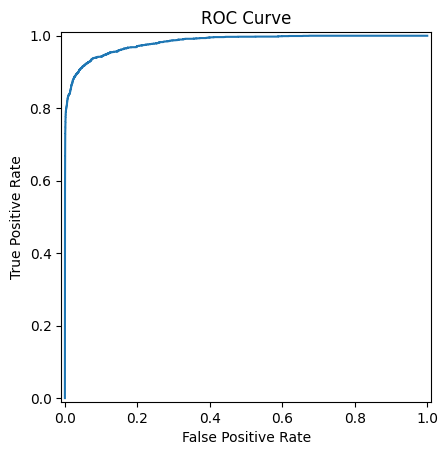

In [35]:
# ROC curve

# Compute ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

# Plot ROC curve
plt.figure(figsize=(5,5))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.title("ROC Curve")
plt.show()

Best F1 threshold: 0.8462
Best F1 score:     0.6281


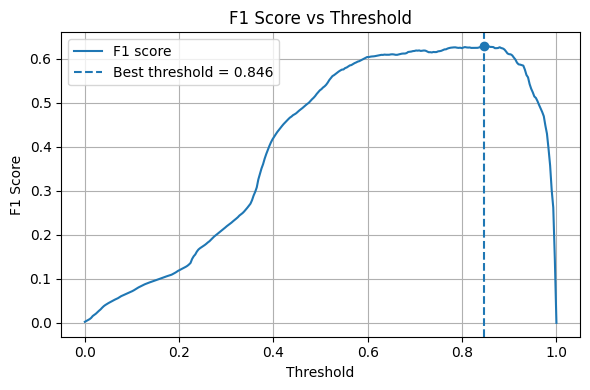

In [34]:
# Threshold-F1 curve

# 1. Compute F1 for a range of thresholds
thresholds = np.linspace(0.0, 1.0, 300)
f1_scores = []

for t in thresholds:
    y_pred = (y_test_pred_proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred))

f1_scores = np.array(f1_scores)

# 2. Find the best threshold (max F1)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best F1 threshold: {best_threshold:.4f}")
print(f"Best F1 score:     {best_f1:.4f}")

# 3. Plot F1 vs threshold with a vertical line at best threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds, f1_scores, label="F1 score")
plt.axvline(best_threshold, linestyle="--", label=f"Best threshold = {best_threshold:.3f}")
plt.scatter([best_threshold], [best_f1], zorder=3)  # mark the best point

plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

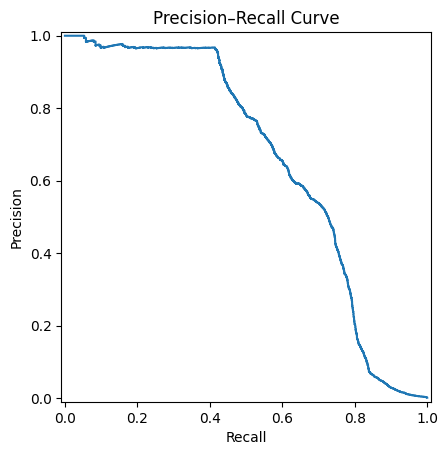

In [33]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba)

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.title("Precision–Recall Curve")
plt.show()

In [ ]:
# Classification report
y_test_pred = (y_test_pred_proba > best_threshold).astype(int)
print("\nClassification report on test set (threshold="+ str(best_threshold) + "):")
print(classification_report(y_test, y_test_pred, digits=3))


Classification report on test set (threshold=0.8461538461538461):
              precision    recall  f1-score   support

           0      0.999     1.000     1.000   2435705
           1      0.697     0.572     0.628      2979

    accuracy                          0.999   2438684
   macro avg      0.848     0.786     0.814   2438684
weighted avg      0.999     0.999     0.999   2438684



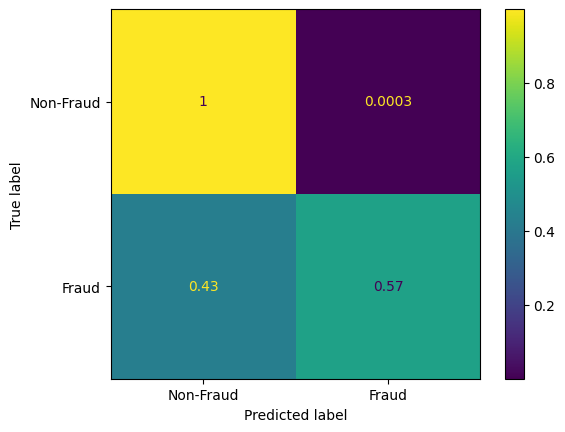

In [37]:
# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
disp.plot()